In [ ]:
## Business Objective

The objective of this project is to predict credit default risk and estimate the probability of default (PD) for loan applicants. The model is designed to support lending decisions by balancing risk exposure with approval rates.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [3]:
Credit_Risk_DF = pd.read_csv("https://raw.githubusercontent.com/Hiddensensu/Credit_Risk_Project/refs/heads/main/synthetic_credit_risk.csv")

In [4]:
Credit_Risk_DF

,age,monthly_income,debt_ratio,credit_utilization,transaction_count_30d,avg_transaction_amount,employment_type,education_level,region,device_type,last_payment_delay_days,internal_score_v2,target
0,43.6,67139.59,0.341,0.508,44,56.04,contract,master,rural,desktop,0.30,546.3,0
1,42.3,69322.76,0.318,0.427,43,71.57,contract,master,urban,desktop,2.16,583.2,0
2,29.4,31240.70,0.380,0.519,43,88.01,full_time,high_school,suburban,tablet,1.14,544.0,0
3,52.5,23838.70,0.372,0.481,50,69.37,full_time,bachelor,urban,tablet,4.56,569.4,0
4,44.0,36584.21,0.129,0.213,44,93.56,contract,bachelor,urban,mobile,1.78,669.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,41.3,76901.04,0.176,0.471,52,59.06,contract,high_school,urban,desktop,3.16,628.2,1
14996,37.3,50768.66,0.488,0.592,47,91.91,full_time,bachelor,suburban,desktop,2.22,480.7,0
14997,47.6,47376.66,0.241,0.411,37,124.75,full_time,high_school,urban,mobile,9.19,575.2,0
14998,23.0,23273.23,0.744,1.000,64,126.09,unemployed,bachelor,suburban,mobile,13.44,376.2,1


In [6]:
Credit_Risk_DF.head(), Credit_Risk_DF.shape

(    age  monthly_income  debt_ratio  credit_utilization  \
 0  43.6        67139.59       0.341               0.508   
 1  42.3        69322.76       0.318               0.427   
 2  29.4        31240.70       0.380               0.519   
 3  52.5        23838.70       0.372               0.481   
 4  44.0        36584.21       0.129               0.213   
 
    transaction_count_30d  avg_transaction_amount employment_type  \
 0                     44                   56.04        contract   
 1                     43                   71.57        contract   
 2                     43                   88.01       full_time   
 3                     50                   69.37       full_time   
 4                     44                   93.56        contract   
 
   education_level    region device_type  last_payment_delay_days  \
 0          master     rural     desktop                     0.30   
 1          master     urban     desktop                     2.16   
 2     high_sch

In [ ]:
target_col = "target"

print("Target rate:", Credit_Risk_DF[target_col].mean())
print(Credit_Risk_DF.dtypes)

missing = Credit_Risk_DF.isna().mean().sort_values(ascending=False)
print(missing[missing > 0])

num_cols = Credit_Risk_DF.select_dtypes(include=[np.number]).columns.drop(target_col)
cat_cols = Credit_Risk_DF.select_dtypes(exclude=[np.number]).columns

Credit_Risk_DF[num_cols].describe().T


Target rate: 0.0772
age                        float64
monthly_income             float64
debt_ratio                 float64
credit_utilization         float64
transaction_count_30d        int64
avg_transaction_amount     float64
employment_type             object
education_level             object
region                      object
device_type                 object
last_payment_delay_days    float64
internal_score_v2          float64
target                       int64
dtype: object
Series([], dtype: float64)


,count,mean,std,min,25%,50%,75%,max
age,15000.0,45.557853,11.014118,18.00,38.200,45.600,52.9000,75.00
monthly_income,15000.0,43234.147455,21169.380032,4024.16,28488.085,39141.395,53188.7350,205203.98
debt_ratio,15000.0,0.334668,0.154811,0.00,0.229,0.328,0.4310,1.00
credit_utilization,15000.0,0.400615,0.196154,0.00,0.265,0.392,0.5210,1.00
transaction_count_30d,15000.0,43.333800,8.584231,18.00,38.000,42.000,47.0000,95.00
avg_transaction_amount,15000.0,92.102736,35.616869,10.00,67.320,91.655,115.6825,239.50
last_payment_delay_days,15000.0,2.586447,3.416169,0.00,0.650,1.620,3.2600,50.43
internal_score_v2,15000.0,587.514093,57.425613,276.50,557.700,592.600,624.8250,750.20


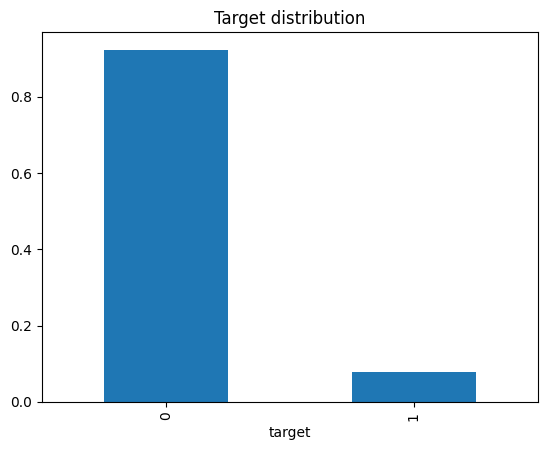

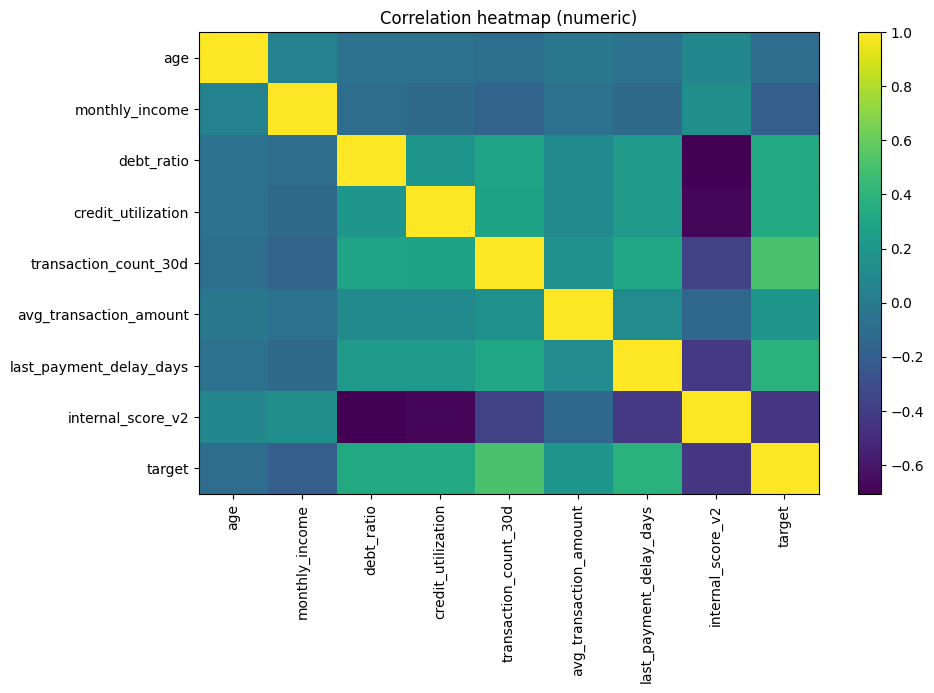

In [9]:
Credit_Risk_DF[target_col].value_counts(normalize=True).plot(kind="bar")
plt.title("Target distribution")
plt.show()

corr = Credit_Risk_DF[num_cols.tolist() + [target_col]].corr()
plt.figure(figsize=(10,6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap (numeric)")
plt.colorbar()
plt.show()

In [10]:
X = Credit_Risk_DF.drop(columns=[target_col])
y = Credit_Risk_DF[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())

(12000, 12) (3000, 12) 0.07716666666666666 0.07733333333333334


In [11]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

ROC AUC: 0.8121698724337254
PR AUC : 0.6921394605535957
[[2764    4]
 [  87  145]]
              precision    recall  f1-score   support

           0     0.9695    0.9986    0.9838      2768
           1     0.9732    0.6250    0.7612       232

    accuracy                         0.9697      3000
   macro avg     0.9713    0.8118    0.8725      3000
weighted avg     0.9698    0.9697    0.9666      3000



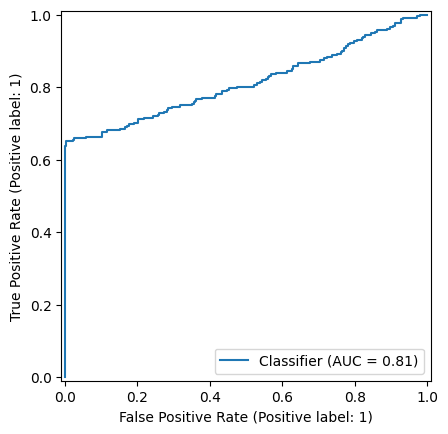

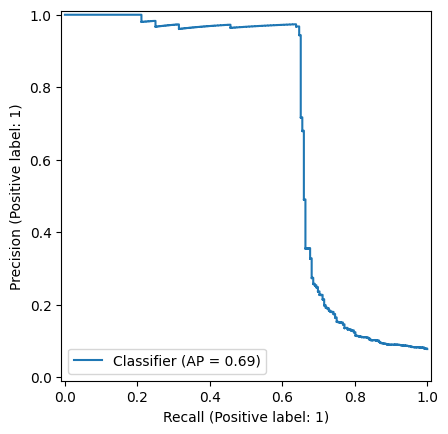

In [12]:
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

baseline.fit(X_train, y_train)

proba_test = baseline.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, proba_test))
print("PR AUC :", average_precision_score(y_test, proba_test))
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=4))

RocCurveDisplay.from_predictions(y_test, proba_test)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_test)
plt.show()

In [13]:
logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    logit, param_grid=param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=1
)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)

best_model = gs.best_estimator_
proba_test = best_model.predict_proba(X_test)[:, 1]
print("Test ROC AUC:", roc_auc_score(y_test, proba_test))
print("Test PR AUC :", average_precision_score(y_test, proba_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 0.05, 'clf__class_weight': None}
Best CV ROC AUC: 0.817597142457019
Test ROC AUC: 0.8120437387881203
Test PR AUC : 0.691678380661344


In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=6,
        max_iter=400,
        random_state=42
    ))
])

hgb.fit(X_train, y_train)
proba_hgb = hgb.predict_proba(X_test)[:, 1]

print("HGB Test ROC AUC:", roc_auc_score(y_test, proba_hgb))
print("HGB Test PR AUC :", average_precision_score(y_test, proba_hgb))

HGB Test ROC AUC: 0.8252021252740682
HGB Test PR AUC : 0.6964962896114618


In [15]:
from sklearn.metrics import precision_recall_curve

model_for_threshold = best_model  # or hgb
proba = model_for_threshold.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, proba)

# Example: choose threshold achieving recall >= 0.80 (catch 80% of defaults)
target_recall = 0.80
idx = np.where(rec >= target_recall)[0][-1]  # last index meeting recall
chosen_thr = thr[idx] if idx < len(thr) else 0.5

print("Chosen threshold:", chosen_thr)
pred = (proba >= chosen_thr).astype(int)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=4))

Chosen threshold: 0.02668357408395918
[[1423 1345]
 [  46  186]]
              precision    recall  f1-score   support

           0     0.9687    0.5141    0.6717      2768
           1     0.1215    0.8017    0.2110       232

    accuracy                         0.5363      3000
   macro avg     0.5451    0.6579    0.4414      3000
weighted avg     0.9032    0.5363    0.6361      3000



In [16]:
res = X_test.copy()
res["y_true"] = y_test.values
res["proba"] = proba
res["pred"] = (proba >= chosen_thr).astype(int)
res["error"] = (res["pred"] != res["y_true"]).astype(int)

false_pos = res[(res.y_true==0) & (res.pred==1)].sort_values("proba", ascending=False).head(10)
false_neg = res[(res.y_true==1) & (res.pred==0)].sort_values("proba", ascending=True).head(10)

false_pos, false_neg

(        age  monthly_income  debt_ratio  credit_utilization  \
 5195   48.6        11417.25       0.582               0.737   
 5908   53.1        20684.97       0.681               0.801   
 3233   28.9        23070.22       0.577               0.927   
 2167   33.2        20521.04       0.676               0.693   
 5004   30.8        11269.62       0.390               0.558   
 13251  43.4        30075.97       0.485               0.491   
 8130   32.6        47388.36       0.638               0.510   
 12631  47.9        17573.52       0.484               0.743   
 5403   48.5        35815.04       0.456               0.779   
 12239  42.7        28828.71       0.327               0.389   
 
        transaction_count_30d  avg_transaction_amount employment_type  \
 5195                      78                  121.48   self_employed   
 5908                      72                  130.40      unemployed   
 3233                      66                  200.13   self_employed   
 2

In [ ]:
## Error Analysis

- False negatives represent high-risk borrowers incorrectly classified as safe,
  which pose the greatest financial risk to lenders.
- False positives represent conservative rejections that may reduce approval rates
  but protect against default losses.
- Threshold tuning was used to prioritize recall for default cases,
  reflecting real-world credit risk tradeoffs.


In [21]:
cols_to_show = [
    "proba",
    "monthly_income",
    "debt_ratio",
    "credit_utilization",
    "transaction_count_30d",
    "employment_type"
]

top_riskiest[cols_to_show], top_safest[cols_to_show]

(          proba  monthly_income  debt_ratio  credit_utilization  \
 6586   0.998669        11981.95       0.716               1.000   
 7541   0.995390        14394.56       0.467               0.962   
 1346   0.995206        24668.95       0.838               0.807   
 14315  0.993242        11119.68       0.854               0.826   
 1139   0.989317        21243.18       0.671               0.961   
 10327  0.984684         9457.83       0.637               0.768   
 3014   0.981472        36053.80       0.873               0.752   
 2009   0.980696         9965.12       0.690               0.951   
 10056  0.978083        21912.24       0.809               0.853   
 14570  0.976626        13767.08       0.737               0.641   
 
        transaction_count_30d employment_type  
 6586                      70      unemployed  
 7541                      79      unemployed  
 1346                      74        contract  
 14315                     68   self_employed  
 1139     

In [ ]:
## Risk Ranking Analysis

The model was used to rank applicants by predicted probability of default.
This allows identification of both the highest-risk and lowest-risk customers,
which is critical for underwriting and monitoring use cases.


In [18]:
r = permutation_importance(
    model_for_threshold,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

imp.head(15)

,feature,importance_mean,importance_std
4,transaction_count_30d,0.013406,0.006452
6,employment_type,0.000737,0.001052
1,monthly_income,0.000021,0.003238
8,region,-0.000253,0.000605
9,device_type,-0.000466,0.000305
7,education_level,-0.000621,0.000579
2,debt_ratio,-0.000636,0.005396
5,avg_transaction_amount,-0.000809,0.002462
0,age,-0.000871,0.000812
11,internal_score_v2,-0.001169,0.001619


In [ ]:
## Model Explainability: Permutation Importance

To better understand which features most influence model performance,
permutation importance was computed using ROC AUC as the evaluation metric.
This measures the decrease in model performance when each feature is randomly shuffled.


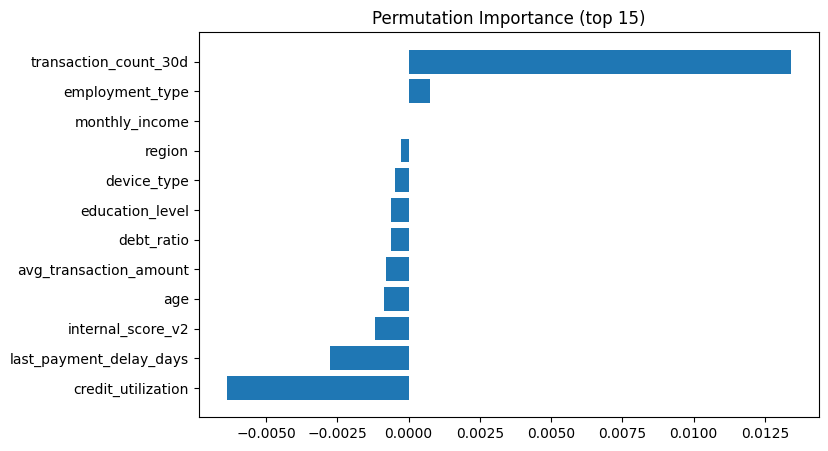

In [19]:
imp_top = imp.head(15).iloc[::-1]
plt.figure(figsize=(8,5))
plt.barh(imp_top["feature"], imp_top["importance_mean"])
plt.title("Permutation Importance (top 15)")
plt.show()

In [ ]:
## Interpretation

- Transaction activity (`transaction_count_30d`) is the most influential feature,
  indicating recent behavioral patterns are highly predictive of default risk.
- Credit utilization and payment delay also contribute meaningfully to model performance.
- Demographic and device-related features have relatively lower importance,
  suggesting financial behavior dominates default prediction.


In [ ]:
## Deployment Considerations

- The final model was serialized using `joblib` for deployment.
- The pipeline can be integrated into a credit decision system
  to generate real-time probability of default (PD) scores.
- Business thresholds can be adjusted dynamically based on risk appetite,
  economic conditions, or portfolio constraints.

In [ ]:
## Key Takeaways

- Recent transaction behavior is the strongest predictor of default risk
- Credit utilization and payment delays materially increase default probability
- Class imbalance requires metrics beyond accuracy (ROC AUC, PR AUC, recall)
- Threshold tuning enables alignment with business risk tolerance
- A well-structured logistic regression pipeline performs competitively and remains interpretable


In [ ]:
import joblib

final_model = model_for_threshold
joblib.dump(final_model, "credit_risk_model.joblib")
print("Saved: credit_risk_model.joblib")

Saved: credit_risk_model.joblib
